# Generate random Gaussian kernels and downscale images

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as img
from scipy.ndimage import filters, measurements, interpolation
import glob
from scipy.io import savemat
import ntpath

## Determine sizes and path

In [2]:
scale_factor = np.array([4, 4])  # choose scale-factor
avg_sf = np.mean(scale_factor)  # this is calculated so that min_var and max_var will be more intutitive
min_var = 0.175 * avg_sf  # variance of the gaussian kernel will be sampled between min_var and max_var
max_var = 2.5 * avg_sf
k_size = np.array([21, 21])  # size of the kernel, should have room for the gaussian
noise_level = 0.4  # this option allows deviation from just a gaussian, by adding multiplicative noise noise
images_path = '.\example\*HR.png'
output_path = '.'

### Function for centering a kernel

In [3]:
def kernel_shift(kernel, sf):
    # There are two reasons for shifting the kernel:
    # 1. Center of mass is not in the center of the kernel which creates ambiguity. There is no possible way to know
    #    the degradation process included shifting so we always assume center of mass is center of the kernel.
    # 2. We further shift kernel center so that top left result pixel corresponds to the middle of the sfXsf first
    #    pixels. Default is for odd size to be in the middle of the first pixel and for even sized kernel to be at the
    #    top left corner of the first pixel. that is why different shift size needed between od and even size.
    # Given that these two conditions are fulfilled, we are happy and aligned, the way to test it is as follows:
    # The input image, when interpolated (regular bicubic) is exactly aligned with ground truth.

    # First calculate the current center of mass for the kernel
    current_center_of_mass = measurements.center_of_mass(kernel)

    # The second ("+ 0.5 * ....") is for applying condition 2 from the comments above
    wanted_center_of_mass = np.array(kernel.shape) / 2 + 0.5 * (sf - (kernel.shape[0] % 2))

    # Define the shift vector for the kernel shifting (x,y)
    shift_vec = wanted_center_of_mass - current_center_of_mass

    # Finally shift the kernel and return
    return interpolation.shift(kernel, shift_vec)

## Function for generating one kernel

In [4]:
def gen_kernel(k_size, scale_factor, min_var, max_var):
    
    # Set random eigen-vals (lambdas) and angle (theta) for COV matrix
    lambda_1 = min_var + np.random.rand() * (max_var - min_var);
    lambda_2 = min_var + np.random.rand() * (max_var - min_var);
    theta = np.random.rand() * np.pi
    noise = -noise_level + np.random.rand(*k_size) * noise_level * 2
    
    # Set COV matrix using Lambdas and Theta
    LAMBDA = np.diag([lambda_1, lambda_2]);
    Q = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    SIGMA = Q @ LAMBDA @ Q.T
    INV_SIGMA = np.linalg.inv(SIGMA)[None, None, :, :]
    
    # Set expectation position (shifting kernel for aligned image)
    MU = k_size // 2  + 0.5 * (scale_factor - k_size % 2)
    MU = MU[None, None, :, None]
    
    # Create meshgrid for Gaussian
    [X,Y] = np.meshgrid(range(k_size[0]), range(k_size[1]))
    Z = np.stack([X, Y], 2)[:, :, :, None]
    
    # Calcualte Gaussian for every pixel of the kernel
    ZZ = Z-MU
    ZZ_t = ZZ.transpose(0,1,3,2)
    raw_kernel = np.exp(-0.5 * np.squeeze(ZZ_t @ INV_SIGMA @ ZZ)) * (1 + noise)
    
    # shift the kernel so it will be centered
    raw_kernel_centered = kernel_shift(raw_kernel, scale_factor)
    
    # Normalize the kernel and return
    kernel = raw_kernel_centered / np.sum(raw_kernel_centered)
    return kernel

## Function for downscaling an image using a kernel

In [5]:
def downscale(im, kernel, scale_factor, output_shape=None):
    # output shape can either be specified or, for simple cases, can be calculated.
    # see more details regarding this at: https://github.com/assafshocher/Resizer
    if output_shape is None:
        output_shape = np.array(im.shape[:-1]) / np.array(scale_factor)
    
#     print(output_shape)
    
    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    for channel in range(np.ndim(im)):
        out_im[:, :, channel] = filters.correlate(im[:, :, channel], kernel)

    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - scale_factor[0], output_shape[0])).astype(int)[:, None],
                  np.round(np.linspace(0, im.shape[1] - scale_factor[1], output_shape[1])).astype(int), :]

## Load images, downscale using kernels, save and display

C:\Users\assafsho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
C:\Users\assafsho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


0


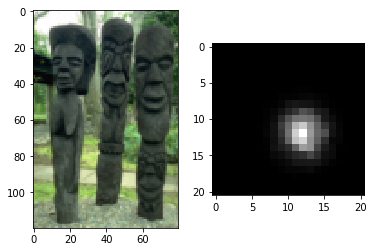

In [6]:
lr_images = []
kernels = []
for i, path in enumerate(glob.glob(images_path)):
    im = img.imread(path)
    kernel = gen_kernel(k_size, scale_factor, min_var, max_var)
    lr = downscale(im, kernel, scale_factor)
    print(i)
    plt.subplot(1, 2, 1)
    plt.imshow(lr)
    plt.subplot(1, 2, 2)
    plt.imshow(kernel, cmap='gray')
    plt.show()
    savemat('%s/im_%d_sf_%d_%d.mat' % (output_path, i, scale_factor[0], scale_factor[1]), {'ker': kernel})
    plt.imsave('%s\im_%d_sf_%d_%d.png' % (output_path, i, scale_factor[0], scale_factor[1]), lr, vmin=0, vmax=1)
